# The National Spotify Stats and Visualization

This is a small project where Spotify Audio Features for my favorite band, The National, are retrieved from the Spotify API with the spotipy library. These audio features for The National are then analyzed and visualized.

Read more about the different Spotify Audio Features here:
<https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject>

## Retrieving Audio Features from Spotify API

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import pandas as pd
import numpy as np

### Oauth2 Authorization

Obtain client_id and client_secret after creating a new app from: <https://developer.spotify.com/dashboard/applications>

In [2]:
start_time = time.time()

client_id = "210e37ebca874b6db50d781e9100f83c"
client_secret = "f4834b95875b438e853f0c4e39987261"

In [3]:
# Client Credentials flow for server-to-server authentication
auth_manager = SpotifyClientCredentials(client_id = client_id,
                                        client_secret = client_secret)
# Spotify Client module
sp = spotipy.Spotify(auth_manager=auth_manager)

### Retrieve all albums of The National on Spotify

In [4]:
national_uri = "spotify:artist:2cCUtGK9sDU2EoElnk0GNB"
results = sp.artist_albums(national_uri, 
                           album_type='album', 
                           country='US')

In [5]:
# initialize some lists to store results
album_names = []
album_uris = []
album_release_dates = []
album_total_tracks = []

In [6]:
# store info for each album in lists
for album in results['items']:
    album_names.append(album['name'])
    album_uris.append(album['uri'])
    album_release_dates.append(album['release_date'])
    album_total_tracks.append(album['total_tracks'])

In [7]:
for album in album_names:
    print(album)

Sad Songs for Dirty Lovers (2021 Remaster)
Juicy Sonic Magic (Live in Berkeley September 24-25 2018)
I Am Easy to Find
Boxer (Live in Brussels)
Sleep Well Beast
Trouble Will Find Me
High Violet (Expanded Edition)
High Violet
High Violet
High Violet
Boxer
Boxer
Alligator
Sad Songs for Dirty Lovers
The National (2021 Remaster)
The National


In [8]:
# create dictionary of album names with release dates
album_date_dict = dict(zip(album_names, album_release_dates))

Several albums like High Violet appear multiple times in the Spotify results

### Retrieve list of tracks for each album
Create a nested dictionary to store track information of each album

In [9]:
def get_album_tracks(name, uri):
    '''
    Retrieves and stores track information for each album
    '''
    
    national_albums[uri] = {} # create nested dictionary for album
    
    # initialize empty lists inside nested dictionary for album
    national_albums[uri]['album'] = []
    national_albums[uri]['track_number'] = []
    national_albums[uri]['name'] = []
    national_albums[uri]['uri'] = []
    national_albums[uri]['duration_ms'] = []
    
    # get album tracks
    tracks = sp.album_tracks(uri, market='US')
    
    for track in tracks['items']:
        national_albums[uri]['album'].append(name)
        national_albums[uri]['track_number'].append(track['track_number'])
        national_albums[uri]['name'].append(track['name'])
        national_albums[uri]['uri'].append(track['uri'])
        national_albums[uri]['duration_ms'].append(track['duration_ms'])

In [10]:
national_albums = {}

for (name, uri) in zip(album_names, album_uris):
    get_album_tracks(name, uri)

In [11]:
def get_track_features(album_uri):
    '''
    Retrieves and stores Spotify audio features and popularity for each track
    '''
    
    print("Retrieving audio features for album: {}".format(national_albums[album_uri]['album'][0]))
    
    feature_list = ['acousticness',
                   'danceability',
                   'energy',
                   'instrumentalness',
                   'liveness',
                   'loudness',
                   'speechiness',
                   'tempo',
                   'valence',
                   'key',
                   'time_signature']

    # initialize to store track features
    for feature in feature_list:
        national_albums[album_uri][feature] = []
    
    national_albums[album_uri]['popularity'] = []
    
    # iterate through each track
    for track in national_albums[album_uri]['uri']:
        try:
            # get track features and popularity
            track_features = sp.audio_features(track)[0]
            track_popularity = sp.track(track)
            
            # popularity is stored in track, separate from audio_features
            national_albums[album_uri]['popularity'].append(track_popularity['popularity'])

            # add audio features for each track
            for feature in feature_list:
                national_albums[album_uri][feature].append(track_features[feature])
                
            time.sleep(1)
            
        # not all tracks have audio features
        except TypeError:
            print("Could not retrieve audio features for track: {}".format(track))
            for feature in feature_list:
                national_albums[album_uri][feature].append("NA")

In [12]:
for album in national_albums:
    get_track_features(album)
    time.sleep(5)

Retrieving audio features for album: Sad Songs for Dirty Lovers (2021 Remaster)
Retrieving audio features for album: Juicy Sonic Magic (Live in Berkeley September 24-25 2018)
Could not retrieve audio features for track: spotify:track:1vqZ6Lza85ENA860s8vtCs
Retrieving audio features for album: I Am Easy to Find
Retrieving audio features for album: Boxer (Live in Brussels)
Retrieving audio features for album: Sleep Well Beast
Retrieving audio features for album: Trouble Will Find Me
Retrieving audio features for album: High Violet (Expanded Edition)
Retrieving audio features for album: High Violet
Retrieving audio features for album: High Violet
Retrieving audio features for album: High Violet
Retrieving audio features for album: Boxer
Retrieving audio features for album: Boxer
Retrieving audio features for album: Alligator
Retrieving audio features for album: Sad Songs for Dirty Lovers
Retrieving audio features for album: The National (2021 Remaster)
Retrieving audio features for album:

In [13]:
# unpack the nested dictionary and convert to a dataframe
national_dict = {}

all_features = list(national_albums[album_uris[0]].keys())

# initialize empty lists in dictionary to store results
for feature in all_features:
    national_dict[feature] = []

# add all results to lists in dictionary
for album in national_albums:
    for feature in national_albums[album]:
        national_dict[feature].extend(national_albums[album][feature])

# create a pandas dataframe
national_df = pd.DataFrame.from_dict(national_dict)

## Dataframe cleaning

There are several duplicate albums present, remasters, and not all albums are major studio releases (Juicy Sonic Magic). The dataframe will be filtered to only the major studio release albums and the original albums (no remasters).

The number of plays/listens are not available from the Spotify API and will need to be manually added to the csv file.

Popularity provides a proxy measurement for the number of listens. 

"The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are." - from <https://developer.spotify.com/documentation/web-api/reference/#object-trackobject>

In [14]:
# drop duplicate tracks
national_df.drop_duplicates(inplace=True)

In [15]:
# Set NA values to be NaN
national_df.replace({'NA': np.nan}, inplace=True)

In [16]:
# show NaNs
national_df[national_df.isna().any(axis=1)]

,album,track_number,name,uri,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,time_signature,popularity
48,Juicy Sonic Magic (Live in Berkeley September ...,15,England - Live at Berkeley 9/25/18,spotify:track:1vqZ6Lza85ENA860s8vtCs,324191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [17]:
# drop row with NaN
national_df.dropna(inplace = True)

Only 1 song, spotify:track:1vqZ6Lza85ENA860s8vtCs England - Live at Berkeley 9/25/18, did not have Audio Features associated with the track.

In [18]:
# set album order
album_order = {
    'The National': 0,
    'Sad Songs for Dirty Lovers': 1,
    'Alligator': 2,
    'Boxer': 3,
    'High Violet': 4,
    'Trouble Will Find Me': 5,
    'Sleep Well Beast': 6,
    'I Am Easy to Find': 7}

national_df['album_order'] = national_df['album'].map(album_order)

In [19]:
# add release dates to albums
national_df['release_date'] = national_df['album'].map(album_date_dict)

In [20]:
# create a new dataframe with only the main studio albums

studio_albums = ['The National',
                'Sad Songs for Dirty Lovers',
                'Alligator',
                'Boxer',
                'High Violet',
                'Trouble Will Find Me',
                'Sleep Well Beast',
                'I Am Easy to Find']

studio_albums_df = national_df[national_df['album']\
                    .isin(studio_albums)]\
                    .sort_values(by = ['album_order', 'track_number'])\
                    .reset_index(drop = True)

In [21]:
# drop Walk Off and Sin-Eaters from data frame
# these songs are included in the High Violet Expanded Edition only
# but Spotify includes them in normal High Violet

studio_albums_df.drop(\
                studio_albums_df[(studio_albums_df['name'] == "Walk Off") |\
                (studio_albums_df['name'] == "Sin-Eaters")].index,\
                inplace = True)

studio_albums_df.reset_index(drop = True, inplace = True)

In [22]:
# manually add play count information
# play count numbers are as of date: 6/8/2021

self_title_plays = [1281845, 
                    3088937,
                    1218489,
                    1157692,
                    997193,
                    912774,
                    934952,
                    751091,
                    741234,
                    807360,
                    864195,
                    751485]

sad_songs_plays = [1768891,
                   1715806,
                   1780187,
                   3072663,
                   1312410,
                   1095993,
                   1467958,
                   918514,
                   1018051,
                   1173215,
                   962723,
                   6372339]

alligator_plays = [8670039,
                   4331870,
                   5257408,
                   3060502,
                   4540408,
                   3649350,
                   2692174,
                   2389235,
                   7576121,
                   6708282,
                   3217581,
                   2652350,
                   11367398]

boxer_plays = [40171669,
               15719873,
               8005891,
               6611856,
               8575874,
               21795721,
               9069977,
               13973435,
               5691351,
               5441227,
               7359820,
               16610896]

high_violet_plays = [23981599,
                     23032229,
                     17302395,
                     11073870,
                     14343894,
                     47072865,
                     17223543,
                     21034278,
                     15596550,
                     20885764,
                     14196499]

twfm_plays = [41048985,
              20718026,
              45572347,
              22400844,
              18772616,
              17798164,
              39385694,
              27834634,
              14850562,
              116835485,
              13232209,
              20300081,
              13818252]

swb_plays = [19079299,
             24326218,
             9753957,
             40426100,
             9100498,
             6687468,
             10757936,
             9924593,
             21573907,
             14699843,
             17950867,
             5281317]

iaetf_plays = [16301113,
               8831840,
               5217054,
               7787081,
               5393360,
               5002414,
               7160744,
               3771923,
               6514362,
               4862993,
               3943524,
               2778104,
               5099694,
               14491881,
               2726548,
               33671086]

all_plays = self_title_plays +\
            sad_songs_plays +\
            alligator_plays +\
            boxer_plays +\
            high_violet_plays +\
            twfm_plays +\
            swb_plays +\
            iaetf_plays

studio_albums_df['plays'] = all_plays

In [23]:
# add relative proportion of plays of each track per album
album_play_sums = studio_albums_df.groupby(['album', 'name'])['plays'].sum()
relative_plays = album_play_sums.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
relative_plays = relative_plays.droplevel('album').to_frame().reset_index()
relative_plays.rename(columns={"plays": "relative plays per album"}, inplace = True)

In [24]:
studio_albums_df = studio_albums_df.merge(relative_plays,
                     on = "name")

In [25]:
# set data types

data_types = {'duration_ms': 'int64',
             'acousticness': 'float64',
             'danceability': 'float64',
             'energy': 'float64',
             'instrumentalness': 'float64',
             'liveness': 'float64',
             'loudness': 'float64',
             'speechiness': 'float64',
             'tempo': 'float64',
             'valence': 'float64',
             'key': 'int64',
             'time_signature': 'int64',
             'popularity': 'int64',
             'album_order': 'int64',
             'plays': 'int64'}

In [26]:
studio_albums_df = studio_albums_df.astype(data_types)
studio_albums_df.dtypes

album                        object
track_number                  int64
name                         object
uri                          object
duration_ms                   int64
acousticness                float64
danceability                float64
energy                      float64
instrumentalness            float64
liveness                    float64
loudness                    float64
speechiness                 float64
tempo                       float64
valence                     float64
key                           int64
time_signature                int64
popularity                    int64
album_order                   int64
release_date                 object
plays                         int64
relative plays per album    float64
dtype: object

In [27]:
studio_albums_df

,album,track_number,name,uri,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,...,speechiness,tempo,valence,key,time_signature,popularity,album_order,release_date,plays,relative plays per album
0,The National,1,Beautiful Head,spotify:track:5qjxbESLSYtV20JKeiwsaZ,188400,0.5470,0.564,0.667,0.04300,0.0959,...,0.0529,148.091,0.5460,4,4,27,0,2001-07-03,1281845,9.490054
1,The National,2,Cold Girl Fever,spotify:track:77JYrFDjiqBSUQ6qMLfhaL,246000,0.7560,0.788,0.392,0.75900,0.1070,...,0.0432,118.013,0.5730,9,4,40,0,2001-07-03,3088937,22.868739
2,The National,3,The Perfect Song,spotify:track:1cZnwa4gquHoJ6jTIAYAkg,195200,0.0268,0.541,0.521,0.28100,0.0913,...,0.0313,125.675,0.4800,7,4,27,0,2001-07-03,1218489,9.021002
3,The National,4,American Mary,spotify:track:1IGBD3TlzViHUHb1FKeEHz,242893,0.5630,0.642,0.318,0.00643,0.0939,...,0.0268,135.867,0.3360,7,4,26,0,2001-07-03,1157692,8.570895
4,The National,5,Son,spotify:track:2qNifuc2Z75HavDfBpCuGf,319733,0.0532,0.762,0.480,0.69300,0.0800,...,0.0303,125.025,0.3050,0,4,25,0,2001-07-03,997193,7.382652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,I Am Easy to Find,12,Dust Swirls In Strange Light,spotify:track:7esYGv7h7qbaUO1q6MdqKh,198800,0.6570,0.603,0.563,0.11600,0.1280,...,0.0344,112.059,0.1860,4,4,36,7,2019-05-17,2778104,2.080140
97,I Am Easy to Find,13,Hairpin Turns,spotify:track:30SPSWQRfDagq4lJ2KoaR0,267520,0.5220,0.650,0.449,0.07020,0.0906,...,0.0471,136.091,0.4160,8,4,40,7,2019-05-17,5099694,3.818459
98,I Am Easy to Find,14,Rylan,spotify:track:6XxPXXqkE4lG7MVkpom6F8,223853,0.4030,0.609,0.789,0.07740,0.0446,...,0.0466,144.050,0.7240,11,4,51,7,2019-05-17,14491881,10.850975
99,I Am Easy to Find,15,Underwater,spotify:track:2jMqVZRotAEs6h6RHkWi0e,81480,0.9940,0.195,0.250,0.96700,0.1340,...,0.0341,78.099,0.0376,5,4,36,7,2019-05-17,2726548,2.041537


In [28]:
# export dataframe to .csv 
studio_albums_df.to_csv("National_studio_albums.csv",
                       index = False)

### Original vs Remastered Albums

In [29]:
self_title = national_df[(national_df['album'] == 'The National') |\
            (national_df['album'] == 'The National (2021 Remaster)')]\
            .sort_values(by = ['track_number', 'album'])\
            .reset_index(drop = True)

In [30]:
sad_songs = national_df[(national_df['album'] == 'Sad Songs for Dirty Lovers') |\
            (national_df['album'] == 'Sad Songs for Dirty Lovers (2021 Remaster)')]\
            .sort_values(by = ['track_number', 'album'])\
            .reset_index(drop = True)

In [31]:
self_title.groupby('album').mean().round(2)

,track_number,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,time_signature,popularity,album_order
album,,,,,,,,,,,,,,,
The National,6.5,219713.08,0.34,0.64,0.46,0.31,0.15,-11.31,0.05,123.32,0.40,4.42,3.67,26.08,0.0
The National (2021 Remaster),6.5,219856.42,0.36,0.64,0.45,0.38,0.15,-11.82,0.05,123.56,0.41,4.58,3.67,18.67,NaN


In [32]:
sad_songs.groupby('album').mean().round(2)

,track_number,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,time_signature,popularity,album_order
album,,,,,,,,,,,,,,,
Sad Songs for Dirty Lovers,6.5,224970.75,0.34,0.51,0.58,0.52,0.16,-8.26,0.04,130.08,0.38,3.58,4.0,29.25,1.0
Sad Songs for Dirty Lovers (2021 Remaster),6.5,225001.92,0.31,0.53,0.59,0.50,0.17,-7.87,0.04,130.11,0.39,4.33,4.0,34.92,NaN


## Visualizations

In [88]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [34]:
# colors from https://matplotlib.org/stable/gallery/color/named_colors.html

album_palette = {
    'The National': 'lightblue',
    'Sad Songs for Dirty Lovers': 'darkorange',
    'Alligator': 'green',
    'Boxer': 'yellow',
    'High Violet': 'blueviolet',
    'Trouble Will Find Me': 'slategrey',
    'Sleep Well Beast': 'blue',
    'I Am Easy to Find': 'pink'}

In [35]:
# groupby album and calculate sums for features

album_sums = studio_albums_df.groupby('album').sum()\
            .drop(columns = ['track_number', 
                             'key', 
                             'time_signature', 
                             'album_order', 
                             'relative plays per album'])

In [36]:
album_sums

,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,plays
album,,,,,,,,,,,,
Alligator,2885302,3.694712,6.788,9.630,3.115712,1.6350,-88.616,0.4626,1625.693,6.9658,502,66112718
Boxer,2585704,5.149070,6.297,7.455,9.487000,1.5615,-102.861,0.3774,1544.000,5.5010,455,159027590
High Violet,2859650,5.490800,5.686,7.859,6.269115,1.2917,-86.832,0.4777,1374.205,4.9050,416,225743486
I Am Easy to Find,3824436,9.992400,8.076,8.837,6.072802,1.8597,-158.893,0.8620,1901.716,4.0739,702,133553721
Sad Songs for Dirty Lovers,2699649,4.102499,6.097,6.921,6.257206,1.8717,-99.067,0.4395,1561.017,4.5330,351,22658750
Sleep Well Beast,3466116,6.209260,6.497,8.355,9.261000,2.1066,-111.428,0.9772,1540.818,4.0600,554,189562003
The National,2636557,4.071112,7.646,5.575,3.666830,1.7894,-135.766,0.5906,1479.841,4.8034,313,13507247
Trouble Will Find Me,3307347,7.244000,6.332,7.914,3.632287,1.4638,-114.482,0.6043,1826.172,3.6510,650,412567899


### Total Plays and Popularity by Album

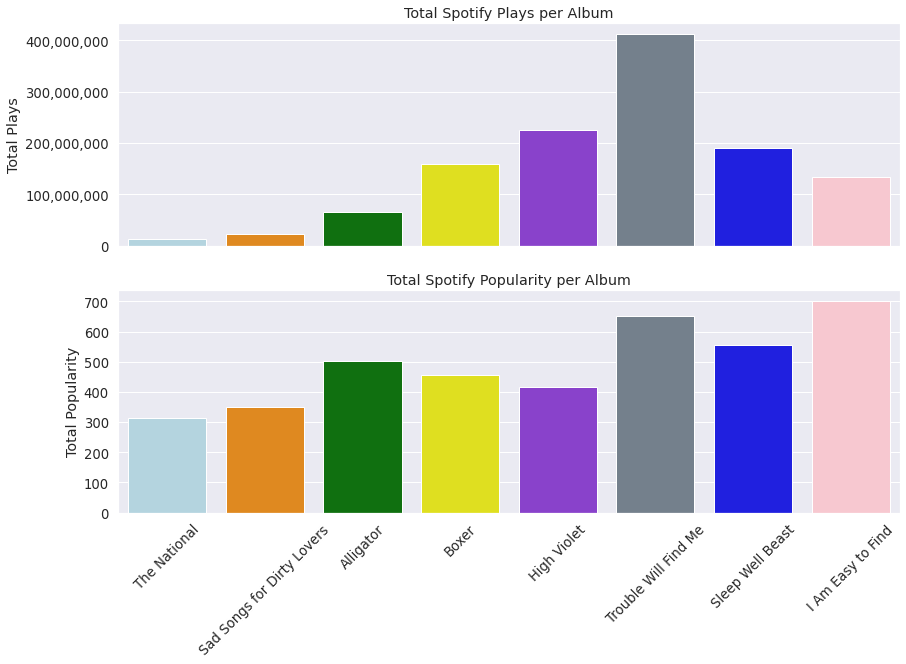

In [122]:
sns.set(font_scale=1.2)
fig, (ax1, ax2) = plt.subplots(nrows = 2,
                               ncols = 1,
                               sharex=True,
                               figsize=(14,9))

# Total Spotify Plays per Album
total_album_plays = sns.barplot(data = album_sums,
                                x = album_sums.index,
                                y = 'plays',
                                order = studio_albums,
                                palette = album_palette,
                                ax = ax1)

# change y ticks from scientific notation to normal notation w/ commas
ylabels = ['{:,.0f}'.format(y) for y in total_album_plays.axes.get_yticks()]
ticks_loc = total_album_plays.get_yticks().tolist()
total_album_plays.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
total_album_plays.set_yticklabels(ylabels)

# Total Spotify Popularity per Album
total_album_plays.set(xlabel = "",
                      ylabel="Total Plays",
                      title ='Total Spotify Plays per Album');

total_album_pop = sns.barplot(data = album_sums,
                              x = album_sums.index,
                              y = 'popularity',
                              order = studio_albums,
                              palette = album_palette,
                              ax = ax2)

total_album_pop.set_xticklabels(total_album_pop.get_xticklabels(), 
                                rotation= 45, 
                                ha = 'center')

total_album_pop.set(xlabel = "",
                    ylabel="Total Popularity",
                    title ='Total Spotify Popularity per Album');

### Track Plays and Popularity by Album

In [97]:
# Swarm Plot
# Violin Plot